# EE511 Final Project

In this file we train the SqueezeNet model as described in the paper found [here](https://arxiv.org/abs/1602.07360).
This implementation uses the CIFAR10 dataset.

## Task 1: Train SqueezeNet

For task 1 we train SqueezeNet for 100 epochs and are able to get a final test accuracy of 80.99%.

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.ao.quantization import QuantStub, DeQuantStub
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import helper

from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device={device}")

Device=cuda


## Implementation

The class in this cell below defines our architecture and defines our forward pass. We insert quantization stub for later Quantization Aware Training. We also define helper functions to save and load the model.

In [ ]:
# import math
# class Fire(nn.Module):
#     def __init__(self, inplanes, squeeze_planes, expand_planes):
#         super(Fire, self).__init__()
#         self.conv1 = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
#         self.relu1 = nn.ReLU()
#         self.conv2 = nn.Conv2d(squeeze_planes, expand_planes, kernel_size=1)
#         self.conv3 = nn.Conv2d(squeeze_planes, expand_planes, kernel_size=3, padding=1)
#         self.relu2 = nn.ReLU()

#         # # MSR initialization
#         # for m in self.modules():
#         #     if isinstance(m, nn.Conv2d):
#         #         n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
#         #         m.weight.data.normal_(0, math.sqrt(2. / n))

#     def forward(self, x):
#         x = self.relu1(self.conv1(x))
#         out1 = self.conv2(x)
#         out2 = self.conv3(x)
#         out = torch.cat([out1, out2], 1)
#         out = self.relu2(out)
#         return out

# class SqueezeNetCIFAR10(nn.Module):
#     def __init__(self, num_classes=10):
#         super(SqueezeNetCIFAR10, self).__init__()
#         # self.quant = QuantStub()
#         # self.dequant = DeQuantStub()

#         # self.upsample = nn.Upsample(size=224, mode='bilinear', align_corners=False)

#         self.conv1 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3)
#         self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

#         self.fire2 = Fire(96, 16, 64)
#         self.fire3 = Fire(128, 16, 64)
#         self.fire4 = Fire(128, 32, 128)
#         self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

#         self.fire5 = Fire(256, 32, 128)
#         self.fire6 = Fire(256, 48, 192)
#         self.fire7 = Fire(384, 48, 192)
#         self.fire8 = Fire(384, 64, 256)
#         self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

#         self.fire9 = Fire(512, 64, 256)
#         self.conv10 = nn.Conv2d(512, num_classes, kernel_size=1)
#         self.avg_pool = nn.AvgPool2d(13)

#     def forward(self, x):
#         # x = self.upsample(x)
#         # x = self.quant(x)
#         x = self.maxpool1(self.conv1(x))

#         x = self.fire2(x)
#         x = self.fire3(x)
#         x = self.fire4(x)
#         x = self.maxpool2(x)

#         x = self.fire5(x)
#         x = self.fire6(x)
#         x = self.fire7(x)
#         x = self.fire8(x)
#         x = self.maxpool3(x)

#         x = self.fire9(x)
#         x = self.conv10(x)
#         x = self.avg_pool(x)
#         x = torch.flatten(x, 1)
#         # x = self.dequant(x)
#         return x
    
#     def load_model(self, path='squeezenet_fp32.pth',device='cpu'):
#         state_dict = torch.load(path,map_location=device)

#         new_state_dict = OrderedDict()
#         for k, v in state_dict.items():
#             if k.startswith('module.'):
#                 k = k[len('module.'):]
#             new_state_dict[k] = v

#         self.load_state_dict(new_state_dict)
#         self.to(device)
#         self.eval()

#         print(f"Model loaded from {path}")
#         # print(self)

#     def save_model(self, path='squeezenet_fp32.pth'):
#         torch.save(self.state_dict(), path)
#         print(f"Model saved to {path}")


## Load the Dataset

In this cell we define a function to load our dataset.

In [40]:
train_loader, test_loader = helper.load_dataset(batch_size=64)

Loading the CIFAR10 dataset
Loaded train data: 50000 total samples, 782 batches
Loaded test data: 10000 total samples, 157 batches


# new try

In [53]:
import torch
class FixedPointQuantizeSTE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, total_bits=8, int_bits=4, signed=True):
        frac_bits = total_bits - int_bits
        scale = 2 ** frac_bits
        
        if signed:
            max_val = (2 ** (int_bits - 1) - 1)
            min_val = -2 ** (int_bits - 1)
        else:
            max_val = (2 ** int_bits - 1)
            min_val = 0
        
        # Quantize
        q_int = torch.clamp(torch.round(input * scale), min_val * scale, max_val * scale)
        q_out = q_int / scale
        return q_out

    @staticmethod
    def backward(ctx, grad_output):
        # STE: pass gradient through unchanged
        return grad_output, None, None, None

def fixed_point_quantize_weights_ste(weights, total_bits=8, int_bits=4):
    return FixedPointQuantizeSTE.apply(weights, total_bits, int_bits, True)

def fixed_point_quantize_activations_ste(activations, total_bits=8, int_bits=4):
    # Use unsigned for post-ReLU activations
    return FixedPointQuantizeSTE.apply(activations, total_bits, int_bits, False)

In [54]:
class Conv2dQuant(nn.Conv2d):
    def __init__(self, in_features, out_features, k, s = 1, p = 0):
        super(Conv2dQuant, self).__init__(in_features, out_features,kernel_size=k,stride=s,padding=p)
        # self.total_bit = total_bit
        # self.int_bit = int_bit

        self.s = s
        self.p = p

    def forward(self, input_):
        w_q = fixed_point_quantize_weights_ste(self.weight)
        # x = fixed_point_quantize_activations_ste(input_)
        return  nn.functional.conv2d(
            input_,
            w_q,
            bias=self.bias,
            stride=self.s,
            padding=self.p,
            dilation=self.dilation,
            groups=self.groups
        )
        # return fixed_point_quantize_activations_ste(x)

In [ ]:
import torch.nn as nn

class Fire(nn.Module):
    def __init__(self, inplanes, squeeze_planes, expand_planes):
        super(Fire, self).__init__()
        self.conv1 = Conv2dQuant(inplanes, squeeze_planes, k=1)
        self.relu1 = nn.ReLU()
        self.conv2 = Conv2dQuant(squeeze_planes, expand_planes, k=1)
        self.conv3 = Conv2dQuant(squeeze_planes, expand_planes, k=3, p=1)
        self.relu2 = nn.ReLU()

    def forward(self, x, epoch=None):
        x = self.conv1(x)
        x = self.relu1(x)
        # print(f"ReLU1 Min value: {x.min().item()}, Max value: {x.max().item()}")
        if epoch and epoch > 3:
            x = fixed_point_quantize_activations_ste(x)
            # x = fixed_point_quantize_activations_ste(x,8,7)  # Quantize once after ReLU
        
        out1 = self.conv2(x)
        out2 = self.conv3(x)
        out = torch.cat([out1, out2], 1)
        
        out = self.relu2(out)
        # print(f"ReLU2: Min value: {x.min().item()}, Max value: {x.max().item()}")
        if epoch and epoch > 3:
            out = fixed_point_quantize_activations_ste(out)
            # out = fixed_point_quantize_activations_ste(out,8,7)  # Quantize once after final ReLU
            
        return out

class SqueezeNetCIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(SqueezeNetCIFAR10, self).__init__()

        # self.conv1 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3)
        self.conv1 = Conv2dQuant(3, 96, k=7, s=2, p=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire2 = Fire(96, 16, 64)
        self.fire3 = Fire(128, 16, 64)
        self.fire4 = Fire(128, 32, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire5 = Fire(256, 32, 128)
        self.fire6 = Fire(256, 48, 192)
        self.fire7 = Fire(384, 48, 192)
        self.fire8 = Fire(384, 64, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire9 = Fire(512, 64, 256)
        # self.conv10 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.conv10 = Conv2dQuant(512, num_classes, k=1)
        self.avg_pool = nn.AvgPool2d(13)

    def forward(self, x, epoch=None):
        x = self.maxpool1(self.conv1(x))
        # x = fixed_point_quantize_activations(x)
        # print(f"MaxPool1: Min value: {x.min().item()}, Max value: {x.max().item()}")
        if epoch and epoch > 3:
            x = fixed_point_quantize_activations_ste(x)
            # x = fixed_point_quantize_activations_ste(x,8,7)

        x = self.fire2(x)
        x = self.fire3(x)
        x = self.fire4(x)
        x = self.maxpool2(x)

        x = self.fire5(x)
        x = self.fire6(x)
        x = self.fire7(x)
        x = self.fire8(x)
        x = self.maxpool3(x)

        x = self.fire9(x)
        x = self.conv10(x)
        x = self.avg_pool(x)
        # x = fixed_point_quantize_activations(x)
        # x = fixed_point_quantize_activations_ste(x)
        x = torch.flatten(x, 1)
        return x
    
    def load_model(self, path='squeezenet_fp32.pth',device='cpu'):
        state_dict = torch.load(path,map_location=device)

        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            if k.startswith('module.'):
                k = k[len('module.'):]
            new_state_dict[k] = v

        self.load_state_dict(new_state_dict)
        self.to(device)
        self.eval()

        print(f"Model loaded from {path}")

    def save_model(self, path='squeezenet_fp32.pth'):
        torch.save(self.state_dict(), path)
        print(f"Model saved to {path}")

In [56]:
model_qat = SqueezeNetCIFAR10().to(device)
model_qat.load_model('squeezenet_fp32_final.pth')

Model loaded from squeezenet_fp32_final.pth


In [ ]:
qat_metrics = helper.train_model(model_qat,
                                 train_loader,
                                 test_loader,
                                 device=device,
                                 epochs=10,
                                 lr=1e-3,
                                 weight_decay=1e-3,
                                 name="squeezenetLR3")

Epoch [1/5] Train Loss: 1.2015, Train Acc: 71.29% Test/Val Loss: 0.7704, Test/Val Acc: 74.32%
Epoch [2/5] Train Loss: 1.2111, Train Acc: 70.80% Test/Val Loss: 0.7488, Test/Val Acc: 75.62%
Epoch [3/5] Train Loss: 1.2195, Train Acc: 70.41% Test/Val Loss: 0.7888, Test/Val Acc: 72.80%
Epoch [4/5] Train Loss: 1.2172, Train Acc: 70.72% Test/Val Loss: 0.7921, Test/Val Acc: 73.57%
Epoch [5/5] Train Loss: 1.2224, Train Acc: 70.46% Test/Val Loss: 0.7814, Test/Val Acc: 76.08%


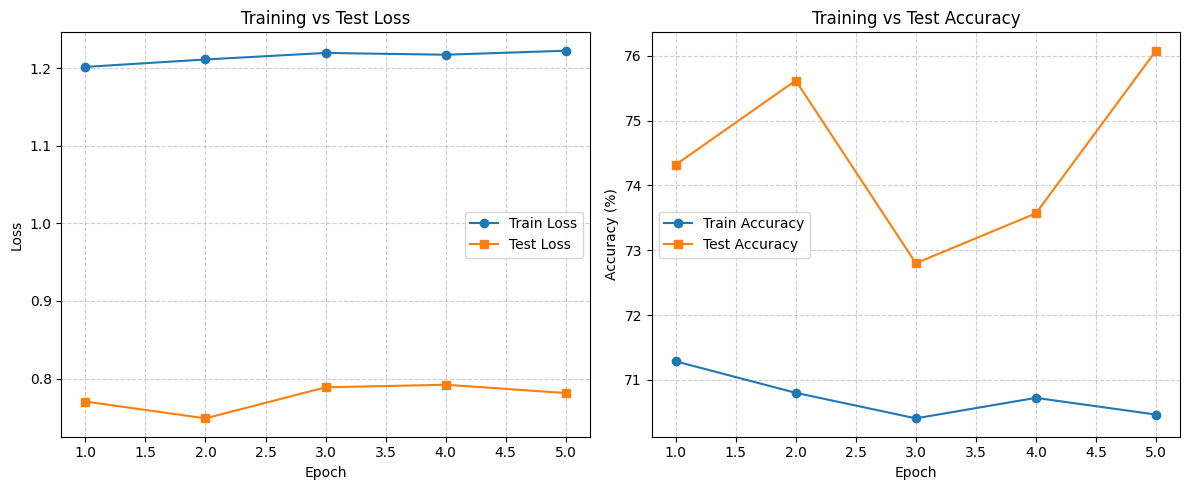

In [58]:
helper.plot_metrics(qat_metrics)

In [ ]:
model_qat.save_model('squeezenet_qatLR3.pth')

Model saved to squeezenet_qat.pth


In [ ]:
qat_metrics = helper.train_model(model_qat,
                                 train_loader,
                                 test_loader,
                                 device=device,
                                 epochs=10,
                                 lr=1e-3,
                                 weight_decay=1e-3,
                                 name="squeezenetLR3")

In [ ]:
helper.plot_metrics(qat_metrics)

In [ ]:
model_qat.save_model('squeezenet_qatLR4.pth')